In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [4]:
df_obs = pd.read_csv("/Net/Groups/BSI/work_scratch/ppapastefanou/atto_summerschool_25/data/ATTO_evaluation.csv")

In [5]:
ds_mod_ass = xr.open_dataset("/Net/Groups/BSI/work_scratch/ppapastefanou/src/QPy/tests/forcing/atto/output/transient_atto/Q_ASSIMI_fluxnetdata_timestep.nc")
ds_mod_veg = xr.open_dataset("/Net/Groups/BSI/work_scratch/ppapastefanou/src/QPy/tests/forcing/atto/output/transient_atto/VEG_fluxnetdata_timestep.nc")
ds_mod_sb = xr.open_dataset("/Net/Groups/BSI/work_scratch/ppapastefanou/src/QPy/tests/forcing/atto/output/transient_atto/SB_fluxnetdata_timestep.nc")

In [6]:
ds_mod_veg['npp_avg']

<xarray.DataArray 'npp_avg' (time: 420480)> Size: 2MB
[420480 values with dtype=float32]
Coordinates:
  * time     (time) object 3MB 2000-01-01 00:00:00 ... 2023-12-31 23:30:00
Attributes:
    units:    micro mol m-2 s-1

In [7]:
df_mod = ds_mod_veg['npp_avg'].to_pandas().to_frame()
df_mod['gpp_avg'] = ds_mod_ass['gpp_avg']
df_mod['nee_avg'] = -(ds_mod_veg['npp_avg'] -ds_mod_sb['het_respiration_avg'] )
#df_mod['nee_avg'] = -(ds_mod_veg['npp_avg'] )

In [8]:
df_mod['Year'] = df_mod.index.year
df_mod['day_of_year_adj'] = df_mod.index.dayofyear
df_mod['Hour'] = df_mod.index.hour
df_mod['Minute'] = df_mod.index.minute

In [9]:
df_merged = pd.merge(
    df_mod,
    df_obs,
    on=["Year", "day_of_year_adj", "Hour", "Minute"],
    how="inner"   # or "outer", "left", "right" depending on your need
)

df_merged['datetime'] = (
    pd.to_datetime(df_merged['Year'].astype(str), format='%Y')  # start of the year
    + pd.to_timedelta(df_merged['day_of_year_adj'], unit='D')  # adjust day of year
    + pd.to_timedelta(df_merged['Hour'], unit='h')
    + pd.to_timedelta(df_merged['Minute'], unit='m')
)
df_merged.set_index('datetime', inplace=True)

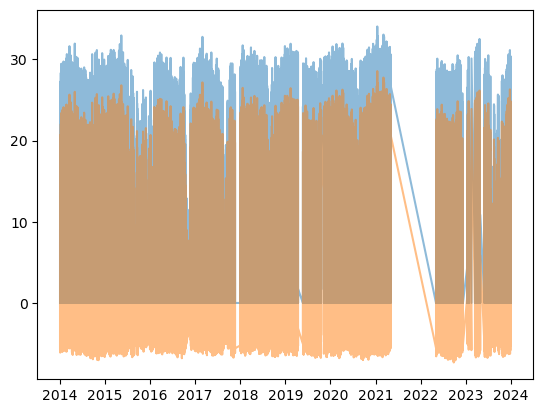

In [10]:
plt.plot(df_merged['gpp_avg'], alpha =0.5)
plt.plot(df_merged['npp_avg'], alpha =0.5)

In [11]:
df_merged['nee_avg']

datetime
2014-01-02 01:30:00     7.824134
2014-01-02 09:30:00   -16.928680
2014-01-02 10:30:00   -17.880871
2014-01-02 11:00:00   -17.568623
2014-01-02 11:30:00   -16.639849
                         ...    
2024-01-01 14:30:00     3.917745
2024-01-01 15:00:00     4.679494
2024-01-01 16:00:00     2.521955
2024-01-01 17:30:00     7.221142
2024-01-01 19:00:00     7.087219
Name: nee_avg, Length: 64519, dtype: float32

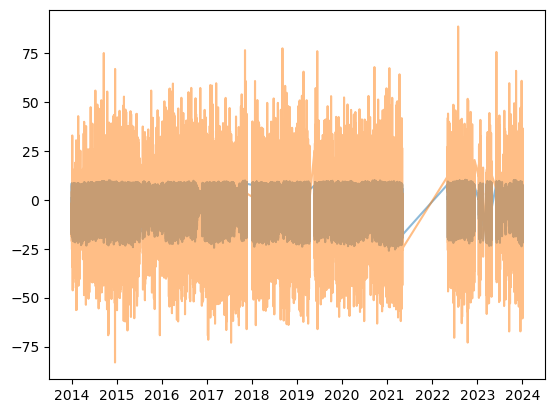

In [12]:
plt.plot(df_merged['nee_avg'], alpha =0.5)
plt.plot(df_merged['NEE_U50_orig'], alpha =0.5)

1.362747926773843


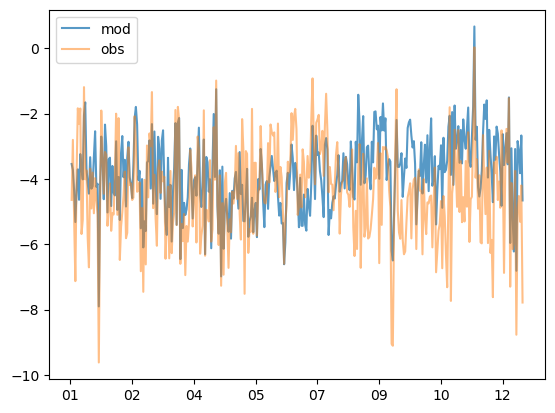

In [ ]:
dfm = df_merged.groupby([df_merged.index.day_of_year ]).agg(
    nee_mean_mod=("nee_avg", "mean"),
    nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
    nee_median_mod=("nee_avg", "median"),
    nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
    
    nee_mean_obs=("NEE_U50_orig", "mean"),
    nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
    nee_median_obs=("NEE_U50_orig", "median"),
    nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
)

plt.plot(dfm['nee_mean_mod'], alpha =0.75, label='mod')
#plt.fill_between(dfm.index, dfm['nee_q25_mod'], dfm['nee_q75_mod'], alpha =0.25, label='mod')
plt.plot(dfm['nee_mean_obs'], alpha =0.5, label='obs')
#plt.fill_between(dfm.index, dfm['nee_q25_obs'], dfm['nee_q75_obs'], alpha =0.25, label='mod')
plt.legend()

vrmse_year = rmse(dfm['nee_mean_mod'], dfm['nee_mean_obs'])
print(vrmse_year)
ax = plt.gca()  # get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))

0.9484128492253276


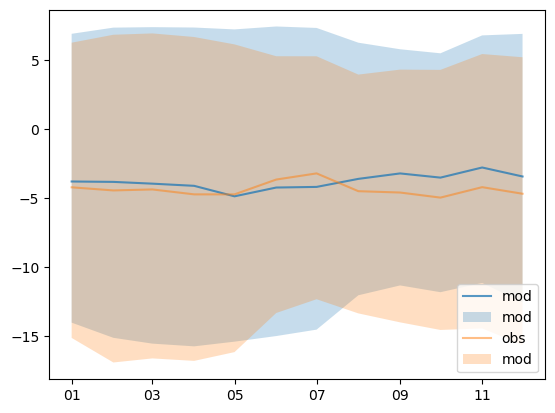

In [ ]:
dfm = df_merged.groupby([df_merged.index.month ]).agg(
    nee_mean_mod=("nee_avg", "mean"),
    nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
    nee_median_mod=("nee_avg", "median"),
    nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
    
    nee_mean_obs=("NEE_U50_orig", "mean"),
    nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
    nee_median_obs=("NEE_U50_orig", "median"),
    nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
)

dfm.index = pd.to_datetime({
    "year": 2000,
    "month": dfm.index.get_level_values(0),
    "day": 1
})

plt.plot(dfm['nee_mean_mod'], alpha =0.75, label='mod')
plt.fill_between(dfm.index, dfm['nee_q25_mod'], dfm['nee_q75_mod'], alpha =0.25, label='mod')
plt.plot(dfm['nee_mean_obs'], alpha =0.5, label='obs')
plt.fill_between(dfm.index, dfm['nee_q25_obs'], dfm['nee_q75_obs'], alpha =0.25, label='mod')
plt.legend()

vrmse_year = rmse(dfm['nee_mean_mod'], dfm['nee_mean_obs'])
print(vrmse_year)
ax = plt.gca()  # get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))

1.763185880453328


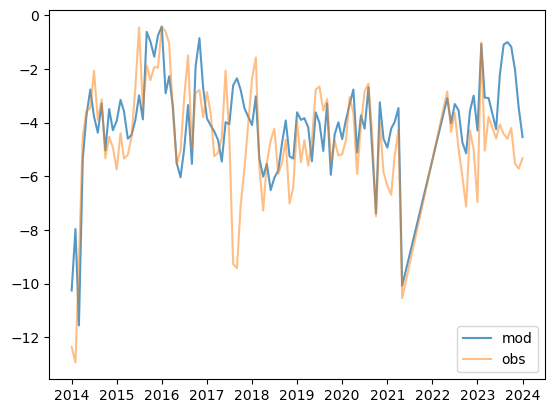

In [42]:
dfm = df_merged.groupby([df_merged.index.year, df_merged.index.month ]).agg(
    nee_mean_mod=("nee_avg", "mean"),
    nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
    nee_median_mod=("nee_avg", "median"),
    nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
    
    nee_mean_obs=("NEE_U50_orig", "mean"),
    nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
    nee_median_obs=("NEE_U50_orig", "median"),
    nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
)



dfm.index = pd.to_datetime({
    "year": dfm.index.get_level_values(0),
    "month": dfm.index.get_level_values(1),
    "day": 1
})

plt.plot(dfm['nee_mean_mod'], alpha =0.75, label='mod')
#plt.fill_between(dfm.index, dfm['nee_q25_mod'], dfm['nee_q75_mod'], alpha =0.25, label='mod')
plt.plot(dfm['nee_mean_obs'], alpha =0.5, label='obs')
#plt.fill_between(dfm.index, dfm['nee_q25_obs'], dfm['nee_q75_obs'], alpha =0.25, label='mod')
plt.legend()

vrmse_year = rmse(dfm['nee_mean_mod'], dfm['nee_mean_obs'])
print(vrmse_year)

3.848161064337297


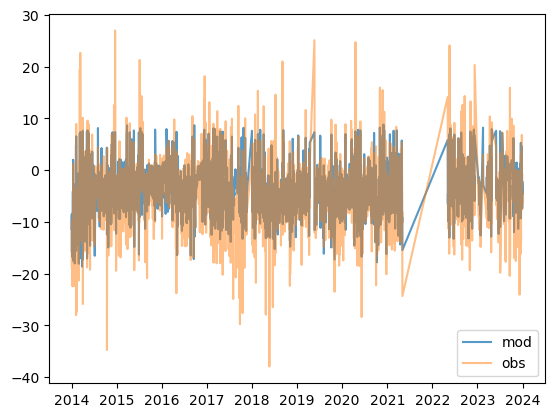

In [44]:
dfm = df_merged.groupby([df_merged.index.year, df_merged.index.dayofyear ]).agg(
    nee_mean_mod=("nee_avg", "mean"),
    nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
    nee_median_mod=("nee_avg", "median"),
    nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
    
    nee_mean_obs=("NEE_U50_orig", "mean"),
    nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
    nee_median_obs=("NEE_U50_orig", "median"),
    nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
)



dfm.index = pd.to_datetime(
    dfm.index.get_level_values(0).astype(str) + "-" +  # year
    dfm.index.get_level_values(1).astype(str),        # day of year
    format="%Y-%j"  # %j = day of year
)

plt.plot(dfm['nee_mean_mod'], alpha =0.75, label='mod')
#plt.fill_between(dfm.index, dfm['nee_q25_mod'], dfm['nee_q75_mod'], alpha =0.25, label='mod')
plt.plot(dfm['nee_mean_obs'], alpha =0.5, label='obs')
#plt.fill_between(dfm.index, dfm['nee_q25_obs'], dfm['nee_q75_obs'], alpha =0.25, label='mod')
plt.legend()

vrmse_year = rmse(dfm['nee_mean_mod'], dfm['nee_mean_obs'])
print(vrmse_year)

3.9631863996237073


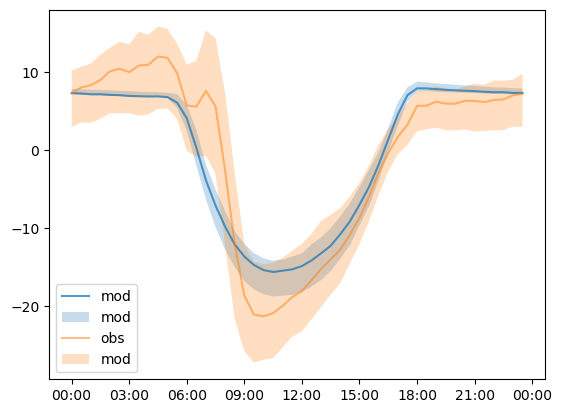

In [29]:
dfm = df_merged.groupby([df_merged.index.hour, df_merged.index.minute ]).agg(
    nee_mean_mod=("nee_avg", "mean"),
    nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
    nee_median_mod=("nee_avg", "median"),
    nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
    
    nee_mean_obs=("NEE_U50_orig", "mean"),
    nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
    nee_median_obs=("NEE_U50_orig", "median"),
    nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
)


dfm.index = pd.to_datetime({
    "year": 2000,
    "month": 1,
    "day": 1, 
    "hour" :dfm.index.get_level_values(0),
    "minute": dfm.index.get_level_values(1)
})


plt.plot(dfm['nee_mean_mod'], alpha =0.75, label='mod')
plt.fill_between(dfm.index, dfm['nee_q25_mod'], dfm['nee_q75_mod'], alpha =0.25, label='mod')
plt.plot(dfm['nee_mean_obs'], alpha =0.5, label='obs')
plt.fill_between(dfm.index, dfm['nee_q25_obs'], dfm['nee_q75_obs'], alpha =0.25, label='mod')
plt.legend()
ax = plt.gca()  # get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

vrmse_year = rmse(dfm['nee_mean_mod'], dfm['nee_mean_obs'])
print(vrmse_year)